# RFD Analysis & K-Means Clustering for Customer Segmentation

In this analysis we will be working with the E-commerce dataset which contains around 150.000 transactions for an UK-based online retailer. The dataset contains actual data for around 4000 customers over the period 2010/2011 grouped by country and transaction day. In this project we will group the consumers based on meaningful similarities.   
Segmentation is used to inform several parts of a business, including product development, marketing campaigns, direct marketing, customer retention, and process optimization 

# 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import squarify

In [2]:
df = pd.read_csv(r'C:\Users\Fabio\Desktop\Data Science\Kaggle Projects\E-Commerce Project\data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str})
df.shape

(541909, 8)

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [4]:
# get some infos on columns types and numer of null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

While looking at the number of null values in the dataframe, it is interesting to note that  ∼ 22% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe.

In [7]:
df = df.dropna(axis=0, subset=['CustomerID'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


OK, therefore, by removing these entries we end up with a dataframe filled at 100% for all variables!
  
Now let's check if there is duplicated data.

In [8]:
df.duplicated().sum()

5225

Lets understand that they are wrong data and drop them. (Other option will be tu summarize them and increase quantity)

In [9]:
df.drop_duplicates(inplace=True, ignore_index=True)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
401599,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
401600,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
401601,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
401602,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


## 2. Exploring the content of variables
This dataframe contains 8 variables that correspond to:

* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides.

## Customers & Invoices

Let's have a first overview of the quantity of values of these categories:

In [10]:
print( 'Number of Customers --> {}'.format(len(df['CustomerID'].value_counts())))
print( 'Number of Invoices  --> {}'.format(len(df['InvoiceNo'].value_counts())))
print( 'Number of Products  --> {}'.format(len(df['StockCode'].value_counts())))

Number of Customers --> 4372
Number of Invoices  --> 22190
Number of Products  --> 3684


###  Cancellation Orders

In [11]:
df[df['InvoiceNo'].str.startswith('C')].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


We can see that in the cancelled orders the Quantity has negative numbers and there is other kind of invoices as Discounts.

In [12]:
n_c = len(df[df['InvoiceNo'].str.startswith('C')]['InvoiceNo'].value_counts())
print( 'Number of Cancellation Orders  --> {}'.format(n_c))

Number of Cancellation Orders  --> 3654


In [13]:
print('Cancellation Orders represent a {:.2f}%'.format(n_c / len(df['InvoiceNo'].value_counts()) * 100))

Cancellation Orders represent a 16.47%


Cancellations do not necessarily correspond to orders that would have been made beforehand. Lets create a new variable with the total quantity cancelled.

In [14]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [15]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


The lines listed in the doubtfull_entry list correspond to the entries indicating a cancellation but for which there is no command beforehand.

In [16]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))

nb of entries to delete: 48


In [17]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

## StockCode

We have seen in the step above that there are different kind of stockcodes, the majority consist of 5 numeric chars.

In [18]:
((df_cleaned['StockCode']).apply(len)).value_counts()

5     358309
6      32583
4       1103
1        362
7        291
2        133
3         16
12        12
Name: StockCode, dtype: int64

Let's see the description of the "special" StockCodes:

In [19]:
special_codes = df_cleaned[((df_cleaned['StockCode']).apply(len) <5) | ((df_cleaned['StockCode']).apply(len) == 12)]['StockCode'].unique()
special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [20]:
for code in special_codes:
    print('{:12}   --> {}'.format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST           --> POSTAGE
D              --> Discount
C2             --> CARRIAGE
M              --> Manual
BANK CHARGES   --> Bank Charges
PADS           --> PADS TO MATCH ALL CUSHIONS
DOT            --> DOTCOM POSTAGE


This indicates that the retailer does not speparate well between special kind of transactions and valid customer-retailer transactions. Let's drop all of these occurences:

In [21]:
for code in special_codes:
    df_cleaned = df_cleaned[df_cleaned['StockCode']!= code]

## Countries
  
What is the number of countries where the company operates?

In [22]:
len(df_cleaned['Country'].unique())

37

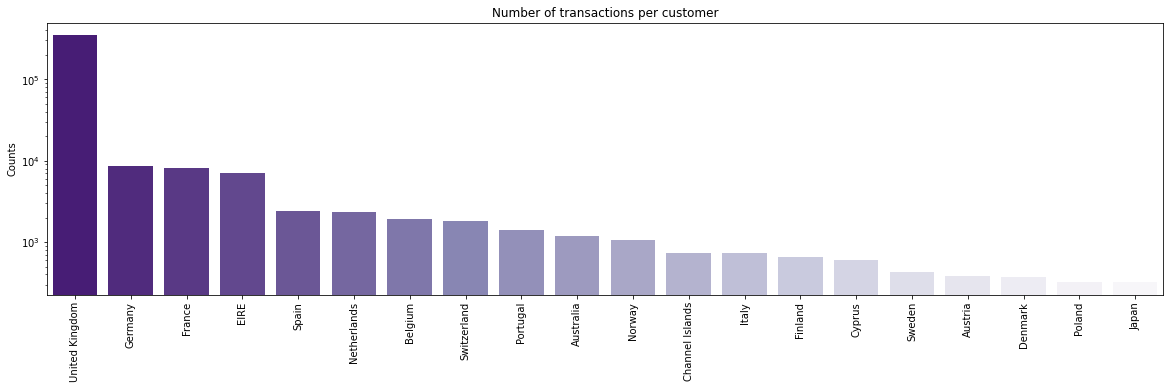

In [23]:
country_counts = df_cleaned['Country'].value_counts().sort_values(ascending=False).iloc[:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Number of transactions per customer");
plt.xticks(rotation=90);
plt.yscale("log")

In [24]:
print('The sales inside UK represents {}% of the total sales.'.format(df_cleaned[df_cleaned['Country']=='United Kingdom'].shape[0] / df_cleaned.shape[0]*100))

The sales inside UK represents 89.18894737245739% of the total sales.


## Unit Price

In [25]:
df_cleaned['UnitPrice'].describe()

count    391183.000000
mean          2.874130
std           4.284639
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

There is some Invoices with UnitPrice of 0, let's drop these rows.

In [26]:
df_cleaned[df_cleaned['UnitPrice']==0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
6842,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647,Germany,0
22619,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom,0
25551,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE,0
29374,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0
29376,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0


In [27]:
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] != 0]

## Quantity

In [28]:
df_cleaned['Quantity'].describe()

count    391150.000000
mean         13.145300
std         180.807831
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [29]:
df_cleaned[df_cleaned['Quantity'] >2000].sort_values('Quantity', ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
401131,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,80995
37511,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215
312064,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901,United Kingdom,0
145108,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135,United Kingdom,0
62425,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087,United Kingdom,0


The two outliers with a huge quantity are orders that have been cancelled. Lets keep everything as it is.

In [30]:
df_cleaned['TotalSales'] = (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled']) * df_cleaned['UnitPrice']

In [31]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


Lets drop from the list the customers that have cancelled all the orders that they have done.

In [78]:
df_cleaned[df_cleaned['TotalSales']==0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalSales
290,536396,82494L,WOODEN FRAME ANTIQUE WHITE,12,2010-12-01 10:51:00,2.55,17850,United Kingdom,12,0.0
1275,536533,22680,FRENCH BLUE METAL DOOR SIGN 5,20,2010-12-01 13:31:00,1.25,16955,United Kingdom,20,0.0
1505,536557,84685,BEACH HUT KEY CABINET,1,2010-12-01 14:41:00,3.75,17841,United Kingdom,1,0.0
1777,536582,22635,CHILDS BREAKFAST SET DOLLY GIRL,2,2010-12-01 16:21:00,9.95,12947,United Kingdom,2,0.0
1835,536591,21427,SKULLS STORAGE BOX SMALL,1,2010-12-01 16:57:00,2.10,14606,United Kingdom,1,0.0


In [80]:
df_cleaned = df_cleaned[df_cleaned['TotalSales']>0]

# 3. What is RFM?
RFM is a data modeling method used to analyze customer value. It stands for recency, frequency, and monetary, which are just three metrics that describe what your customers did. 

* **Recency** measures the time (usually in days) between when your customer last ordered to today. 
* **Frequency** measures how many total orders the customers had.  
* **Monetary** is the average amount they spent from those orders.

In [82]:
df_cleaned['InvoiceDate'].describe()

count                  388571
unique                  17068
top       2011-11-14 15:27:00
freq                      541
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [33]:
# Adjust today:
today = dt.datetime(2012,1,1)
print(today)

2012-01-01 00:00:00


###  Recency, Monetary and Frequency

In [83]:
#Create a dataframe with the Recency, Monetary and Frequency for each Customer.
df_RFM = df_cleaned.groupby(by='CustomerID').agg({'InvoiceNo' : 'count', 
                                                  'TotalSales':'sum', 
                                                   'InvoiceDate': lambda x: (today - x.max()).days})

df_RFM.rename(columns={"InvoiceNo": "Frequency", "TotalSales": "Monetary", "InvoiceDate": "Recency"}, inplace=True)

In [84]:
df_RFM.head()

,Frequency,Monetary,Recency
CustomerID,,,
12347,182,4310.00,24
12348,27,1437.24,97
12349,72,1457.55,40
12350,16,294.40,332
12352,70,1265.41,58


### RFM Segmentation


RFM analysis involves categorising Recency,Frequency and Monetary into 3 or more categories. For convenience, let's create 4 categories based on quartiles (quartiles roughly divide the sample into 4 segments equal proportion).
   
Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

In [85]:
quartiles = df_RFM.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

      Frequency   Monetary  Recency
0.25       17.0   299.6650     39.0
0.50       41.0   653.2150     72.0
0.75       98.0  1611.4325    165.0 <class 'pandas.core.frame.DataFrame'>


In [86]:
quartiles=quartiles.to_dict()
quartiles

{'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 98.0},
 'Monetary': {0.25: 299.66499999999996,
  0.5: 653.2149999999999,
  0.75: 1611.4325000000006},
 'Recency': {0.25: 39.0, 0.5: 72.0, 0.75: 165.0}}

In the case of recency, lower is better then our categorising scheme need to be reverse.

In [87]:
## for Recency 
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
## for Frequency and Monetary value 
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4  

In [88]:
df_RFM['F_Quartile'] = df_RFM['Frequency'].apply(FMClass, args=('Frequency',quartiles,))
df_RFM['M_Quartile'] = df_RFM['Monetary'].apply(FMClass, args=('Monetary',quartiles,))
df_RFM['R_Quartile'] = df_RFM['Recency'].apply(RClass, args=('Recency',quartiles,))

For analysis it is critical to combine the scores to create a single score. There are few approaches. One approach is to just concatenate the scores to create a 3 digit number between 111 and 444. 

In [89]:
df_RFM['RFM_Score'] = df_RFM.R_Quartile.map(str) + df_RFM.F_Quartile.map(str) + df_RFM.M_Quartile.map(str)

In [90]:
df_RFM.head()

,Frequency,Monetary,Recency,F_Quartile,M_Quartile,R_Quartile,RFM_Score
CustomerID,,,,,,,
12347,182,4310.00,24,4,4,4,444
12348,27,1437.24,97,2,3,2,223
12349,72,1457.55,40,3,3,3,333
12350,16,294.40,332,1,1,1,111
12352,70,1265.41,58,3,3,3,333


We can answer some business questions about our clients:

* Who are my best customers?

In [91]:
df_RFM[df_RFM['RFM_Score'] == '444'].sort_values('Monetary', ascending=False).head()

,Frequency,Monetary,Recency,F_Quartile,M_Quartile,R_Quartile,RFM_Score
CustomerID,,,,,,,
14646,2058,278742.02,23,4,4,4,444
18102,431,259657.30,22,4,4,4,444
17450,336,193417.63,30,4,4,4,444
14911,5476,129075.91,23,4,4,4,444
14156,1375,113720.20,31,4,4,4,444


* Who are the loyal customers?

In [92]:
 #Customers with high frequency value
df_RFM[df_RFM['F_Quartile'] >= 3 ].sort_values('Monetary', ascending=False).head()

,Frequency,Monetary,Recency,F_Quartile,M_Quartile,R_Quartile,RFM_Score
CustomerID,,,,,,,
14646,2058,278742.02,23,4,4,4,444
18102,431,259657.30,22,4,4,4,444
17450,336,193417.63,30,4,4,4,444
14911,5476,129075.91,23,4,4,4,444
12415,654,123638.18,46,4,4,3,344


### RFM Score

This RFM score, is simply the sum of the individual R, F, and M scores, obtained by giving equal weights to each RFM attribute.

In [93]:
df_RFM['RFM_Sum'] = df_RFM['R_Quartile'] + df_RFM['F_Quartile'] +df_RFM['M_Quartile']

In [94]:
df_RFM

,Frequency,Monetary,Recency,F_Quartile,M_Quartile,R_Quartile,RFM_Score,RFM_Sum
CustomerID,,,,,,,,
12347,182,4310.00,24,4,4,4,444,12
12348,27,1437.24,97,2,3,2,223,7
12349,72,1457.55,40,3,3,3,333,9
12350,16,294.40,332,1,1,1,111,3
12352,70,1265.41,58,3,3,3,333,9
...,...,...,...,...,...,...,...,...
18280,10,180.60,299,1,1,1,111,3
18281,7,80.82,202,1,1,1,111,3
18282,12,176.60,29,1,1,4,411,6


In [95]:
# Define rfm_segment function
def rfm_segment(df):
    if df['RFM_Sum'] >= 10:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Sum'] >= 9) and (df['RFM_Sum'] < 10)):
        return 'Champions'
    elif ((df['RFM_Sum'] >= 7) and (df['RFM_Sum'] < 9)):
        return 'Loyal'
    elif ((df['RFM_Sum'] >= 5) and (df['RFM_Sum'] < 7)):
        return 'Regular'
    elif ((df['RFM_Sum'] >= 4) and (df['RFM_Sum'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

In [96]:
df_RFM['Customer_Segment'] = df_RFM.apply(rfm_segment, axis=1)

In [97]:
df_RFM.head()

,Frequency,Monetary,Recency,F_Quartile,M_Quartile,R_Quartile,RFM_Score,RFM_Sum,Customer_Segment
CustomerID,,,,,,,,,
12347,182,4310.00,24,4,4,4,444,12,Can't Loose Them
12348,27,1437.24,97,2,3,2,223,7,Loyal
12349,72,1457.55,40,3,3,3,333,9,Champions
12350,16,294.40,332,1,1,1,111,3,Require Activation
12352,70,1265.41,58,3,3,3,333,9,Champions


In [98]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = df_RFM.groupby('Customer_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean', 
    'Monetary' : ['mean', 'count']})


In [99]:
rfm_level_agg.head()

Recency   Frequency     Monetary      
                        mean        mean         mean count
Customer_Segment                                           
Can't Loose Them   41.706869  225.107827  5082.177125  1252
Champions          67.297030   78.262376  1367.485767   404
Loyal              93.059848   47.175190   845.855397   919
Needs Attention   194.072727   13.436364   236.346104   385
Regular           147.658084   24.026777   431.616169   971

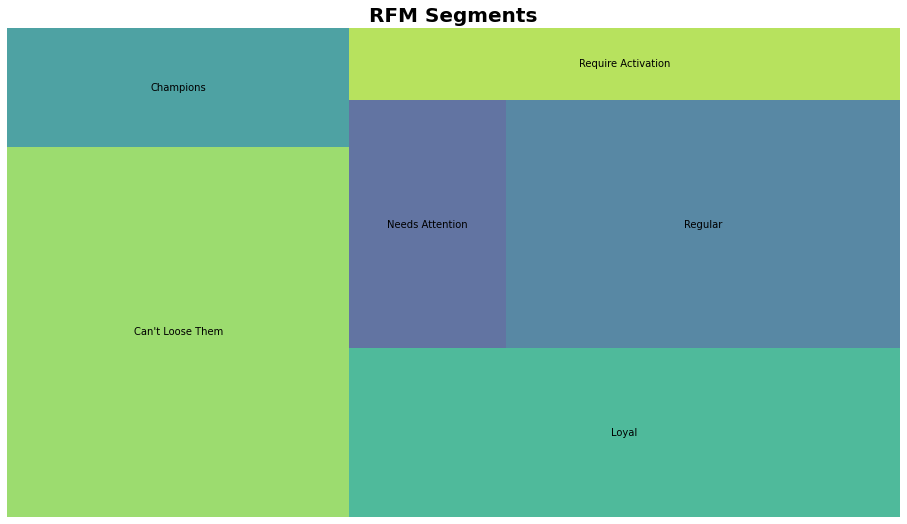

In [100]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Regular', 
                     'Require Activation'], alpha=.8 )
plt.title("RFM Segments",fontsize=20,fontweight="bold")
plt.axis('off')
plt.show()

# 4. K-Means clustering

Key k-means assumptions
* Symmetric distribution of variables (not skewed)
* Variables with same average values
* Variables with same variance

### Exploring Distribution of Frequency, Monetary and Recency

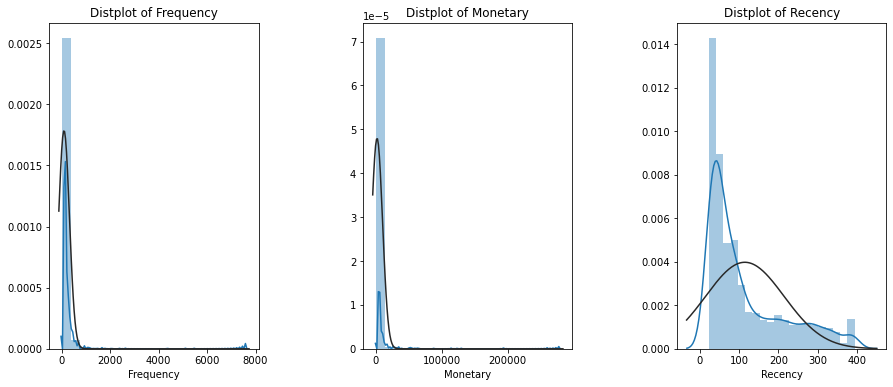

In [101]:
from scipy.stats import norm

plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Frequency' , 'Monetary' , 'Recency']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df_RFM[x] , bins = 20, fit=norm)
    plt.title('Distplot of {}'.format(x))
plt.show()

Below we will apply data transformations to manage skewness: Logarithmic transformation

### Analyze key statistics

In [102]:
df_RFM[['Frequency','Monetary','Recency']].describe()

,Frequency,Monetary,Recency
count,4324.000000,4324.000000,4324.000000
mean,89.863784,1911.236899,114.345282
std,223.305027,8313.359053,100.263088
min,1.000000,2.900000,22.000000
25%,17.000000,299.665000,39.000000
50%,41.000000,653.215000,72.000000
75%,98.000000,1611.432500,165.000000
max,7607.000000,278742.020000,395.000000


K-means works better on variables with the same mean and standard deviation.  We have to standardize to the same average values
and scale to the same standard deviation; we will do this applying a Scaler.

In [103]:
#Unskew the data with log transformation
df_RFM_log = np.log(df_RFM[['Frequency','Monetary','Recency']]).copy()

In [107]:
#Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_RFM_log)

#Store it separately for clustering
RFM_normalized = scaler.transform(df_RFM_log)

In [111]:
# Create the final dataframe to work with a Clustering problem
df_RFM_normalized = pd.DataFrame(data = RFM_normalized, index = df_RFM_log.index, columns = df_RFM_log.columns)

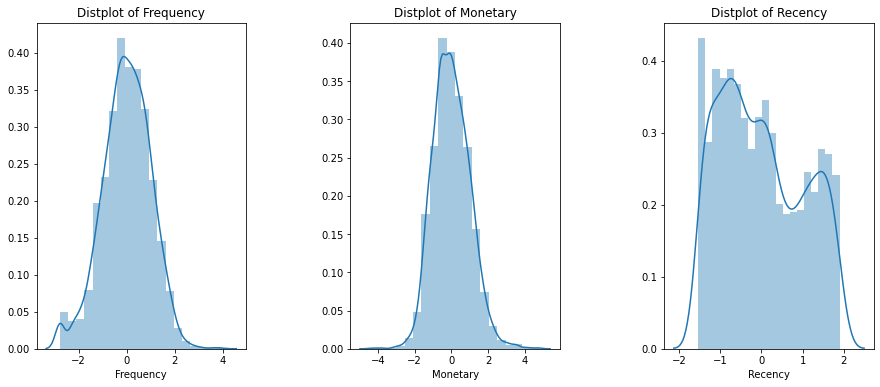

In [112]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Frequency' , 'Monetary' , 'Recency']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df_RFM_normalized[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

### Select the number of clusters: Elbow Method

In [116]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1 , 13):
    algorithm = (KMeans(n_clusters = k ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111) )
    algorithm.fit(df_RFM_normalized)
    inertia.append(algorithm.inertia_)

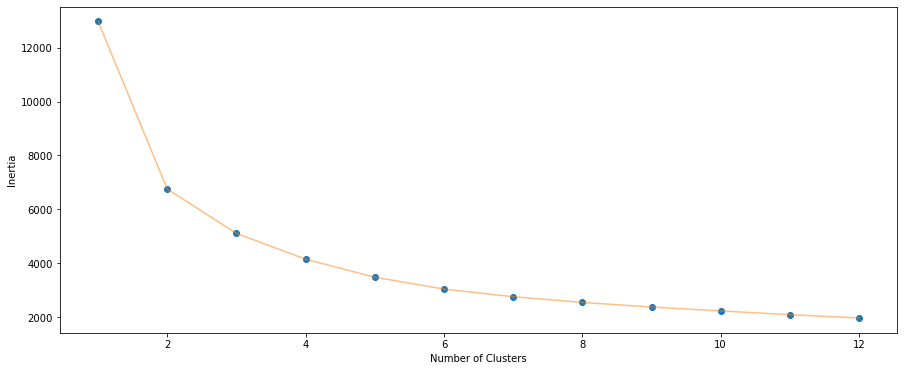

In [118]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 13) , inertia , 'o')
plt.plot(np.arange(1 , 13) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

Lets use the same number of clusters that we used before in our analysis.

In [138]:
kmeans = KMeans(n_clusters=6, init='k-means++', n_init =10,max_iter = 300)
kmeans.fit(df_RFM_normalized[['Frequency' , 'Monetary' , 'Recency']])

KMeans(n_clusters=6)

In [153]:
six_cluster_df = df_RFM_normalized.copy(deep=True)
six_cluster_df['Cluster'] = kmeans.labels_
six_cluster_df.head()

,Frequency,Monetary,Recency,Cluster
CustomerID,,,,
12347,1.165312,1.449006,-1.429153,1
12348,-0.276999,0.572652,0.229740,3
12349,0.464372,0.583850,-0.822415,2
12350,-0.672502,-0.692579,1.691189,5
12352,0.443078,0.471046,-0.381087,2


In [154]:
six_cluster_df.groupby('Cluster').agg('mean')

,Frequency,Monetary,Recency
Cluster,,,
0,-0.711541,-0.729968,-0.387329
1,1.388537,1.528660,-0.984362
2,0.435647,0.290595,-0.884357
3,0.371232,0.412945,0.403481
4,-1.704702,-1.357810,1.211052
5,-0.422972,-0.574157,1.307818


In [155]:
six_cluster_df['Cluster'].value_counts()

2    936
0    816
3    761
5    752
1    651
4    408
Name: Cluster, dtype: int64

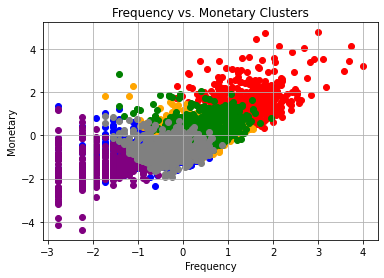

In [156]:
# Visualising the clusters
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 0]['Frequency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 0]['Monetary'],
c='blue')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 1]['Frequency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 1]['Monetary'],
c='red')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 2]['Frequency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 2]['Monetary'],
c='orange')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 3]['Frequency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 3]['Monetary'],
c='green')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 4]['Frequency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 4]['Monetary'],
c='purple')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 5]['Frequency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 5]['Monetary'],
c='grey')
plt.title('Frequency vs. Monetary Clusters')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.grid()
plt.show()

The costumers in red (Cluster 1) they are the most valuable customers, with the higher total sales and number of orders. For the other side the customers in purple have low total sales AND low order count, meaning they are all-around low-value customers. 

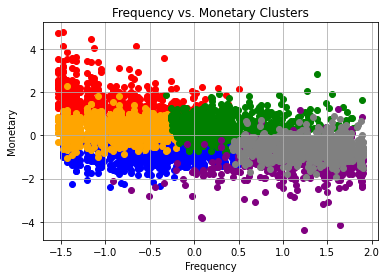

In [161]:
# Visualising the clusters
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 0]['Recency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 0]['Monetary'],
c='blue')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 1]['Recency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 1]['Monetary'],
c='red')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 2]['Recency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 2]['Monetary'],
c='orange')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 3]['Recency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 3]['Monetary'],
c='green')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 4]['Recency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 4]['Monetary'],
c='purple')
plt.scatter(
six_cluster_df.loc[six_cluster_df['Cluster'] == 5]['Recency'], 
six_cluster_df.loc[six_cluster_df['Cluster'] == 5]['Monetary'],
c='grey')
plt.title('Frequency vs. Monetary Clusters')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.grid()
plt.show()

We can see that the blue cluster although has not much importance in terms of total sales and frequency. Its recency is high, new customers that make their first purchase recently.

In [160]:
import plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x= six_cluster_df['Recency'],
    y= six_cluster_df['Monetary'],
    z= six_cluster_df['Frequency'],
    mode='markers',
     marker=dict(
        color = six_cluster_df['Cluster'], 
        size= 20,
        line=dict(
            color= six_cluster_df['Cluster'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Recency'),
            yaxis = dict(title  = 'Monetary'),
            zaxis = dict(title  = 'Frequency')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

# Discussion
Based in the results of our analysis we should share the clusters of customers with other teams of the company(e.g. Marketing), helping them to take new actions.


# Conclusion
Identifying the different types of customers will help us to identify the most profitable customers, optimize the marketing spend, increase customer litime value and implement optimal marketing channel selection for each segment.  
This studio could help as a first starting point, we could upgrade and extend the analysis taking in account kind of products purchased, countries and so on.